Intuitively, we would expect that coronavirus spreads more rapidly in dense areas. Let's check to see if our intuition plays out in the data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-population-density-by-county/TX Counties - Population Data.csv
/kaggle/input/us-population-density-by-county/NY Counties - Population Data.csv
/kaggle/input/uncover/UNCOVER_v4/UNCOVER/hackathon_file_readme.txt
/kaggle/input/uncover/UNCOVER_v4/UNCOVER/coronadatascraper/coronadatascraper-timeseries.csv
/kaggle/input/uncover/UNCOVER_v4/UNCOVER/OpenTable/restaurant-performance.csv
/kaggle/input/uncover/UNCOVER_v4/UNCOVER/howsmyflattening/howsmyflattening/ontario-testing-data.csv
/kaggle/input/uncover/UNCOVER_v4/UNCOVER/howsmyflattening/howsmyflattening/ontario-icu-capacity.csv
/kaggle/input/uncover/UNCOVER_v4/UNCOVER/howsmyflattening/howsmyflattening/canada-testing-data.csv
/kaggle/input/uncover/UNCOVER_v4/UNCOVER/covid_tracker_canada/covid-19-tracker-canada.csv
/kaggle/input/uncover/UNCOVER_v4/UNCOVER/regional_sources/the_belgian_institute_for_health/dataset-of-confirmed-cases-by-date-and-municipality.csv
/kaggle/input/uncover/UNCOVER_v4/UNCOVER/regional_sources/governmen

In [2]:
###
# Create the county population data frames
###
tx_cnty_df = pd.read_csv('/kaggle/input/us-population-density-by-county/TX Counties - Population Data.csv', thousands=',')
ny_cnty_df = pd.read_csv('/kaggle/input/us-population-density-by-county/NY Counties - Population Data.csv', thousands=',')

ny_cnty_df.sample(5)

,FIPS,County,2010_CensusPopulation,2010_Area_sqmi,2010_PopDensity,2015_EstimatedPopulation,2015_PopDensity
57,36115,Washington,63216,831.18,76.06,62230,74.87
19,36031,Essex,39370,1794.23,21.94,38478,21.45
39,36075,Oswego,122109,951.65,128.31,120146,126.25
3,36081,Queens,2230722,108.53,20553.97,2339150,21553.03
52,36105,Sullivan,77547,968.13,80.10,74877,77.34


First, let's visualize some of the population data. 

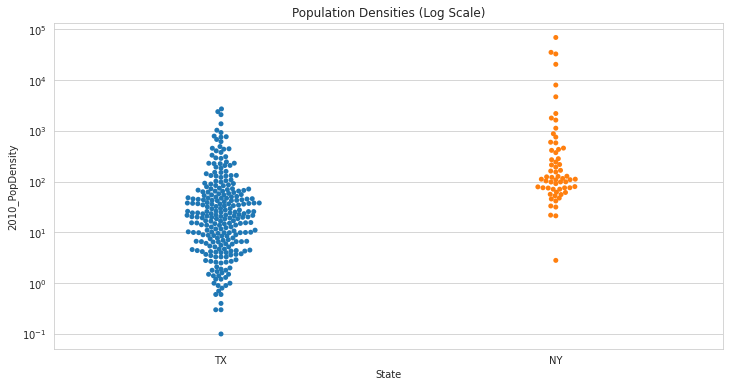

In [3]:
###
# Start to visualize the data
###
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')

tx_cnty_df['State'] = 'TX'
ny_cnty_df['State'] = 'NY'
cols = ['FIPS', 'County', '2010_CensusPopulation', '2010_Area_sqmi', '2010_PopDensity','State']
cnty_df = pd.concat([tx_cnty_df, ny_cnty_df[cols]])

# cnty_df.head()

# cnty_df['2010_PopDensity'] = pd.to_numeric(cnty_df['2010_PopDensity'])

plt.figure(figsize=(12,6))
plt.yscale('log')
plt.title('Population Densities (Log Scale)')
ny_cnty_df.head()
sns.swarmplot(x=cnty_df['State'], y=cnty_df['2010_PopDensity'])

We can see that New York and Texas have different population density profiles. We also know from experience that New York and Texas have different testing rates, with New York testing over three times as many people per capita (as of May 20). Let's focus primarily on one state first. We'll use New York.

In [4]:
###
# DataFrame for NY county population stats
###
# Renaming to save keystrokes
df = ny_cnty_df

# drop columns that we don't care about
drop_columns = ['2015_EstimatedPopulation', '2015_PopDensity', 'State']
df = df.drop(columns=drop_columns)

# rename columns to fit the function
rename_columns = {'2010_CensusPopulation': 'Population', '2010_Area_sqmi': 'Size', '2010_PopDensity': 'PopDensity'}
df = df.rename(columns=rename_columns)

df

,FIPS,County,Population,Size,PopDensity
0,36005,Bronx,1385108,42.10,32900.43
1,36047,Kings,2504700,70.82,35367.13
2,36061,New York,1585873,22.83,69464.43
3,36081,Queens,2230722,108.53,20553.97
4,36085,Richmond,468730,58.37,8030.32
...,...,...,...,...,...
57,36115,Washington,63216,831.18,76.06
58,36117,Wayne,93772,603.83,155.30
59,36119,Westchester,949113,430.50,2204.68
60,36121,Wyoming,42155,592.75,71.12


We are interested in seeing if population density is a reliable feature for predicting infections/deaths per million. For smaller counties, we won't have enough of a population to gather meaningful data, so let's combine some of the counties together and re-calculate the population density.

We'll want groups of counties of similar population size, arranged by their population density. We'll define a function to make those groups

In [5]:
###
# Combine populations
###

def county_groups(df, num_groups=None, grp_pop_trgt=None):
    """
    Groups together counties by density. Each county group will be similarly populated.
    
    Inputs:
      - df - Dataframe with columns ['FIPS', 'County', 'Population']
      - num_groups - the number of groups to collect counties into. Input will be rounded to nearest integer
      - grp_pop_trgt - the target population for each group. Used to calculate num_groups. If num_groups is 
                      specified, grp_pop_trgt is ignored. Grp_pop_target will be updated to the nearest
                      rational number.
    """
    # Check inputs
    total_population = df['Population'].sum()
    
    if (num_groups is not None) and (num_groups > 0): 
        num_groups = int(round(num_groups))
        grp_pop_trgt = total_population / num_groups
    elif grp_pop_trgt > total_population:
        print("grp_pop_trgt is larget than the state's total population")
        return None
    elif grp_pop_trgt > 0:
        num_groups = int(round(total_population / grp_pop_trgt))
        grp_pop_trgt = total_population / num_groups
    else:
        print("grp_pop_trgt or num_groups must be a positive number")
    
    # Establish variables for loop
    df.sort_values('PopDensity', inplace=True)
    grp = 0
    cnty_grps = list()
    cnty_grps.append(list())
    fips_grps = list()
    fips_grps.append(list())
    grped_pop = 0
    
    # iterate and group counties
    for index, row in df.iterrows():
        # target population for this group
        if grped_pop + row["Population"] <= grp_pop_trgt:
            grped_pop += row["Population"]
            cnty_grps[grp].append(row['County'])
            fips_grps[grp].append(row['FIPS'])

        else:
            # determine whether this row or last row is closer to the target
            last_row_diff = abs(grped_pop - grp_pop_trgt)
            this_row_diff = abs(grped_pop + row["Population"] - grp_pop_trgt)

            # Last row closer, so put the new row into a new group
            if last_row_diff < this_row_diff:
                cnty_grps.append(list())
                fips_grps.append(list())
                grp += 1
                grped_pop = row['Population']
                cnty_grps[grp].append(row['County'])
                fips_grps[grp].append(row['FIPS'])
            # Current row is closer, so stick it in the last group before creating a new one
            else:
                cnty_grps[grp].append(row['County'])
                cnty_grps.append(list())
                fips_grps.append(list())
                grp += 1
                grped_pop = 0

    return cnty_grps, fips_grps



In [6]:
# Make groups
df
most_populous = df['Population'].max()
ny_cnty_groups, ny_fips_groups = county_groups(df, grp_pop_trgt = most_populous)

# Create a dataframe to show the size of each group
i = 0
group_name = list()
num_counties = list()
total_pop = list()
total_area = list()
avg_popDensity = list()
for group in ny_cnty_groups:
    group_df = df[df['County'].isin(group)]
    group_name.append(f'Group {i}')
    num_counties.append(len(group))
    total_pop_val = group_df['Population'].sum()
    total_area_val = group_df['Size'].sum()
    pop_density_val = total_pop_val / total_area_val
    total_pop.append(total_pop_val)
    total_area.append(total_area_val)
    avg_popDensity.append(pop_density_val)
    # grp_list.append([group_name, num_counties, total_pop, total_area, avg_popDensity])
    i += 1

data = {'group_name':group_name, 'num_counties':num_counties, 'total_population':total_pop, 'total_area':total_area, 'population_density':avg_popDensity}
summary_df = pd.DataFrame(data)
    
summary_df

,group_name,num_counties,total_population,total_area,population_density
0,Group 0,37,2420627,34550.68,70.060184
1,Group 1,12,2403523,7789.47,308.560531
2,Group 2,4,2285137,2682.81,851.769973
3,Group 3,3,2754150,1516.10,1816.601807
4,Group 4,2,1808262,343.09,5270.517940
5,Group 5,1,2230722,108.53,20553.966645
6,Group 6,1,1385108,42.10,32900.427553
7,Group 7,1,2504700,70.82,35367.127930
8,Group 8,1,1585873,22.83,69464.432764


In [7]:
def missing_column_value_check(df1, df2, column):
    
    df1_set = set(df1[column])
    df2_set = set(df2[column])

    missing_from_df1_set = df2_set.difference(df1_set)
    if len(missing_from_df1_set) > 0:
        print(f'Missing {column} from first dataframe')
        print(df1[df1[column].isin(missing_from_df1_set)])

    missing_from_df2_set = df1_set.difference(df2_set)
    if len(missing_from_df2_set) > 0:
        print(f'Missing {column} from second dataframe')
        print(df2[df2[column].isin(missing_from_df2_set)])

    if (len(missing_from_df1_set) == 0) & (len(missing_from_df2_set) == 0):
        print(f'No differences in {column}')

In [8]:
file = '/kaggle/input/uncover/UNCOVER_v4/UNCOVER/USAFacts/confirmed-covid-19-deaths-in-us-by-state-and-county.csv'

# Load the NY county data
usa_facts_deaths_df = pd.read_csv(file)
usa_facts_deaths_df.columns = ['FIPS', 'County', 'State', 'State_FIPS', 'Date', 'Deaths', 'Lat', 'Long', 'Geometry']
usa_facts_deaths_df = usa_facts_deaths_df[(usa_facts_deaths_df['State'] == 'NY') & (usa_facts_deaths_df['FIPS'] > 1)]

# Clean up the data
usa_facts_deaths_df['County'] = usa_facts_deaths_df['County'].str.replace(' County','')
usa_facts_deaths_df['County'] = usa_facts_deaths_df['County'].str.replace('St. Lawrence','St Lawrence')


# Check if deaths dataframe contains data from all counties
print('FIPS Check')
print('----------')
missing_column_value_check(df, usa_facts_deaths_df, 'FIPS')
print(f'\n\nCounty Name Check')
print('-------------------')
missing_column_value_check(df, usa_facts_deaths_df, 'County')

FIPS Check
----------
No differences in FIPS


County Name Check
-------------------
No differences in County


In [9]:
file = '/kaggle/input/uncover/UNCOVER_v4/UNCOVER/USAFacts/confirmed-covid-19-cases-in-us-by-state-and-county.csv'

# Load the NY County data
usa_facts_cases_df = pd.read_csv(file)
usa_facts_cases_df.columns = ['FIPS', 'County', 'State', 'State_FIPS', 'Date', 'Cases', 'Lat', 'Long', 'Geometry']
usa_facts_cases_df = usa_facts_cases_df[(usa_facts_cases_df['State'] == 'NY') & (usa_facts_cases_df['FIPS'] > 1)]

# Clean up the data
usa_facts_cases_df['County'] = usa_facts_cases_df['County'].str.replace(' County','')
usa_facts_cases_df['County'] = usa_facts_cases_df['County'].str.replace('St. Lawrence','St Lawrence')


# Check if cases dataframe contains data from all counties
print('FIPS Check')
print('----------')
missing_column_value_check(df, usa_facts_cases_df, 'FIPS')
print(f'\n\nCounty Name Check')
print('-------------------')
missing_column_value_check(df, usa_facts_cases_df, 'County')

FIPS Check
----------
No differences in FIPS


County Name Check
-------------------
No differences in County


Check to see if counties are missing from either data set

In [10]:
right_cases_cols = ['FIPS', 'Date', 'Cases']
ny_combined_df = df.merge(usa_facts_cases_df[right_cases_cols], how='inner', on='FIPS')

right_deaths_cols = ['FIPS', 'Date', 'Deaths'] #, 'Lat', 'Long', 'Geometry']
ny_combined_df = ny_combined_df.merge(usa_facts_deaths_df[right_deaths_cols], how='inner', on=['FIPS', 'Date'])

# First date with Covid Data
first_covid_date = ny_combined_df[(ny_combined_df['Cases'] > 0) | (ny_combined_df['Deaths'] > 0)].Date.min()

ny_combined_df = ny_combined_df[ny_combined_df['Date'] >= first_covid_date]
ny_combined_df

,FIPS,County,Population,Size,PopDensity,Date,Cases,Deaths
40,36041,Hamilton,4836,1717.37,2.82,2020-03-02,0,0
41,36041,Hamilton,4836,1717.37,2.82,2020-03-03,0,0
42,36041,Hamilton,4836,1717.37,2.82,2020-03-04,0,0
43,36041,Hamilton,4836,1717.37,2.82,2020-03-05,0,0
44,36041,Hamilton,4836,1717.37,2.82,2020-03-06,0,0
...,...,...,...,...,...,...,...,...
7373,36061,New York,1585873,22.83,69464.43,2020-05-15,24832,2610
7374,36061,New York,1585873,22.83,69464.43,2020-05-16,24982,2625
7375,36061,New York,1585873,22.83,69464.43,2020-05-17,25130,2639
7376,36061,New York,1585873,22.83,69464.43,2020-05-18,25216,2648


Plot the cases and deaths of lowest density

In [11]:
i = 0
final_df = pd.DataFrame(columns = ['Group', 'Population','Size', 'PopDensity', 'Date', 'Cases', 'Deaths', 'Cases per Million', 'Deaths per Million'])

for group in ny_cnty_groups:
    # Gather stats for group by date
    filtered_df = ny_combined_df[ny_combined_df['County'].isin(group)]
    group_counties_df = filtered_df.groupby('Date', as_index=False)['Cases', 'Deaths'].sum()
    group_counties_df['Group'] = f'Group {i}'
    
    # Some counties may be missing reported data for some dates in the covid_df, so gather population and size from the summary_df
    group_counties_df['Population'] = summary_df.loc[i, 'total_population']
    group_counties_df['Size'] = summary_df.loc[i, 'total_area']
    group_counties_df['PopDensity'] = summary_df.loc[i, 'population_density']
    
    # Normalize death and case rates by population
    group_counties_df['Cases per Million'] = group_counties_df['Cases'] / group_counties_df['Population'] * 1000000
    group_counties_df['Deaths per Million'] = group_counties_df['Deaths'] / group_counties_df['Population'] * 1000000
    
    final_df = final_df.append(group_counties_df, ignore_index=True)
    i += 1

final_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,Group,Population,Size,PopDensity,Date,Cases,Deaths,Cases per Million,Deaths per Million
0,Group 0,2420627,34550.68,70.060184,2020-03-02,0,0,0.000000,0.000000
1,Group 0,2420627,34550.68,70.060184,2020-03-03,0,0,0.000000,0.000000
2,Group 0,2420627,34550.68,70.060184,2020-03-04,0,0,0.000000,0.000000
3,Group 0,2420627,34550.68,70.060184,2020-03-05,0,0,0.000000,0.000000
4,Group 0,2420627,34550.68,70.060184,2020-03-06,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
706,Group 8,1585873,22.83,69464.432764,2020-05-15,24832,2610,15658.252584,1645.781220
707,Group 8,1585873,22.83,69464.432764,2020-05-16,24982,2625,15752.837711,1655.239732
708,Group 8,1585873,22.83,69464.432764,2020-05-17,25130,2639,15846.161704,1664.067678
709,Group 8,1585873,22.83,69464.432764,2020-05-18,25216,2648,15900.390510,1669.742785


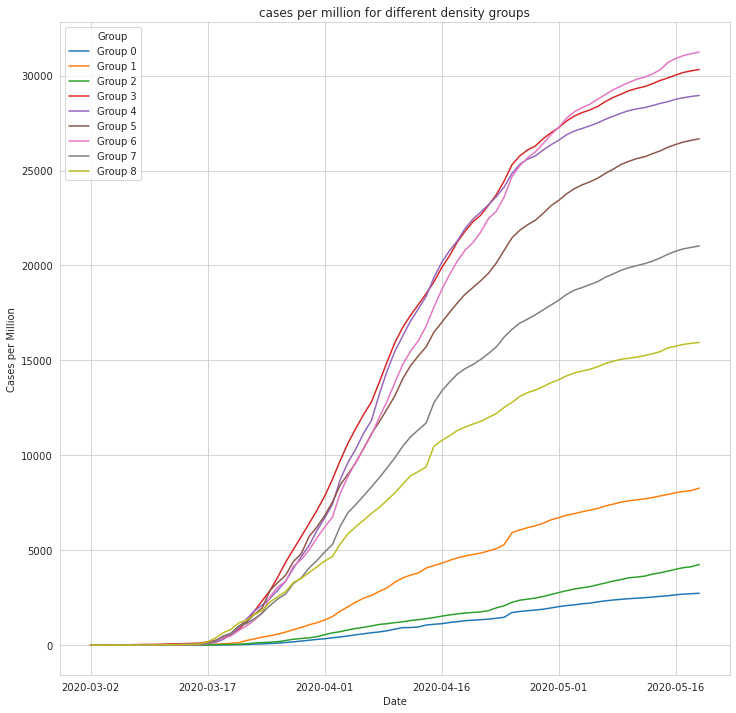

In [12]:
# Plot the results
plt.figure(figsize=(12,12))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.title('cases per million for different density groups')
sns.lineplot(data=final_df, ax=ax, x='Date', y='Cases per Million', hue='Group')

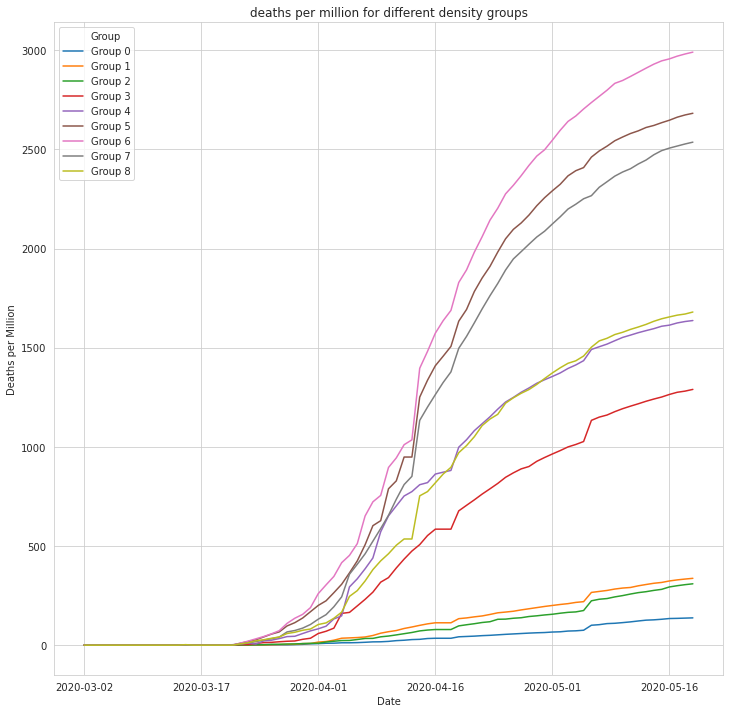

In [13]:


plt.figure(figsize=(12,12))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.title('deaths per million for different density groups')
sns.lineplot(data=final_df, ax=ax, x='Date', y='Deaths per Million', hue='Group')

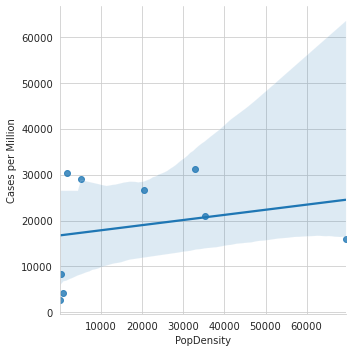

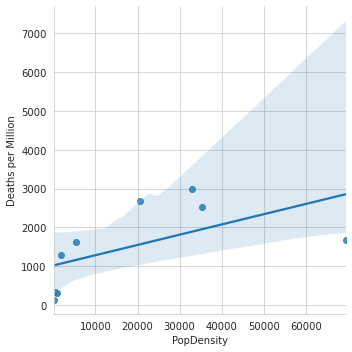

In [14]:
latest_date = final_df['Date'].max()
latest_df = final_df[final_df['Date'] == latest_date]

sns.lmplot(data=latest_df, x='PopDensity', y='Cases per Million')
sns.lmplot(data=latest_df, x='PopDensity', y='Deaths per Million')
